In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
This program reads in an input argument (which is expected to be
a positive integer) and write some text to a file with name
dummy_*.txt where * is the input argument 


"""

import sys 
import os
import numpy as np 
import random
import matplotlib.pyplot as plt

class job:
    def __init__(self, arrivalTime, serviceTime, group, index):
        self.arrivalTime = arrivalTime
        self.serviceTime = float(serviceTime)
        self.group = group
        self.departureTime = float(arrivalTime) + float(serviceTime)
        self.eventTime = arrivalTime
        self.index = index
        self.type = "Arrival"

def readFile(n, fileName):
    file = []
    with open (f"config/{fileName}_{n}.txt") as data:
        for row in data:
            file.append(row.replace('\n', ''))
        return file
    
def add_to_jobs(jobList, job):
    jobList.append(job)
    jobList.sort(key=lambda x: x.eventTime)

def queue_to_server(queue, jobList, masterclock):
    nextJob = queue.pop(0)
    nextJob.eventTime = masterclock
    add_to_jobs(jobList, nextJob)
    # print("server has a space, move from queue to server")

def log(job, masterclock):
    print("Master clock:", masterclock)
    print("Job:", job.index)
    print("Job group:", job.group)
    print("Job type:", job.type)
    print("Arrival Time", job.arrivalTime)
    print("Service Time:", job.serviceTime)

def mrt(jobs):
    response_times = {"0":0,"1":0}
    n = {"0":0, "1":0}
    mean = {"0":0, "1":0}
    for arr_time, dep_time, group in jobs:
        if group != "r0":
            mean[group] += (dep_time - arr_time)
            n[group] += 1
            
    response_times["0"] = mean["0"] / n["0"]
    response_times["1"] = mean["1"] / n["1"]

    return response_times

def output(s, completed_jobs):
    with open(f"output/mrt_{s}.txt", "w") as mrt_file:
                mrt_file.write(f"{mrt(completed_jobs)["0"]} "+ f"{mrt(completed_jobs)["1"]}")

    # Save dep values to a file
    with open(f"output/dep_{s}.txt", "w") as dep_file:
        for l in completed_jobs:
            dep_file.write(" ".join(map(str, l)) + "\n")

def generate_groups(p0, n):
    jobsGroup = []
    for _ in range(n):
        random_number = random.random()
        if random_number < p0:
            jobsGroup.append("0")
        else:
            jobsGroup.append("1")
    return jobsGroup


def generate_arrivals(Lamba, alpha_2l, alpha_2u, endTime):
    arrivalTime = []

    a1k = np.random.exponential(1 / Lamba)
    a2k = np.random.uniform(alpha_2l, alpha_2u)
    while True:
        if not arrivalTime:
            ak = a1k * a2k
        else:
            ak = arrivalTime[-1] + (a1k * a2k)
        if ak > endTime:
            break
        arrivalTime.append(ak)
    return arrivalTime

def inverse_pdf0(g, alpha, beta, eta):
    gamma = alpha**(-eta) - beta**(-eta)
    return (eta/(gamma * g)) ** (1/(eta+1))

def inverse_pdf1(g, alpha, eta):
    gamma = alpha**(-eta)
    return (eta/(gamma * g)) ** (1/(eta+1))

def generate_services(alpha0, beta0, eta0, alpha1, eta1, interArrivalTime, jobsGroup):
    serviceTime = []
    rand_values = np.random.uniform(size=len(interArrivalTime))
    for i in range(len(interArrivalTime)):
        if jobsGroup[i] == "0":
            serviceTime.append(inverse_pdf0(rand_values[i], alpha0, beta0, eta0))
        else:
            serviceTime.append(inverse_pdf1(rand_values[i], alpha1, eta1))

    return serviceTime

def get_all_jobs(mode, interArrivalFile, serviceFile, paraFile):
    arrivalTime = []
    serviceTime = []
    jobsGroup = []

    jobList = []

    if mode == "trace":
        interArrivalTime = list(float(i) for i in interArrivalFile)

        for line in serviceFile:
            serviceTime.append(line.split(" ")[0])
            jobsGroup.append(line.split(" ")[1])

        arrivalTime = np.cumsum(interArrivalTime)
        
        for i in range(len(interArrivalFile)):
            jobList.append(job(arrivalTime[i], serviceTime[i], jobsGroup[i], index=i))

    elif mode == "random":
        endTime = int(paraFile[3])
        Lamba, alpha_2l, alpha_2u = tuple(float(e) for e in interArrivalFile[0].split())
        p0 = float(serviceFile[0])
        alpha0, beta0, eta0  = tuple(float(e) for e in serviceFile[1].split())
        alpha1, eta1  = tuple(float(e) for e in serviceFile[2].split())

        arrivalTime = generate_arrivals(Lamba, alpha_2l, alpha_2u, endTime)
        jobsGroup = generate_groups(p0, len(arrivalTime))
        serviceTime = generate_services(alpha0, beta0, eta0, alpha1, eta1, arrivalTime, jobsGroup)
        
        for i in range(len(arrivalTime)):
            jobList.append(job(arrivalTime[i], serviceTime[i], jobsGroup[i], index=i))
        
        
    return jobList

def moving_k_wmrt(jobs, k):
    response_times = {"0":0,"1":0}
    n = {"0":0, "1":0}
    sum = {"0":0, "1":0}
    start_index = max(0, len(jobs) - k)  # Start index for the moving window
    for i in range(start_index, len(jobs)):
        arrivalTime = jobs[i][0]
        departureTime = jobs[i][1]
        group = jobs[i][2]

        if group != "r0":
            sum[group] += (departureTime - arrivalTime)
            n[group] += 1
            
    # Only calculate the mean for non-zero counts to avoid division by zero
    response_times["0"] = sum["0"] / n["0"] if n["0"] > 0 else 0
    response_times["1"] = sum["1"] / n["1"] if n["1"] > 0 else 0

    wmrt = 0.83*response_times["0"] + 0.059*response_times["1"]
    return wmrt

        

def main(s, i):
    # Read all files:
    interArrivalFile = readFile(s, 'interarrival')
    mode = readFile(s, 'mode')[0]
    paraFile = readFile(s, 'para')
    serviceFile = readFile(s, 'service')

    n = int(paraFile[0])
    n0 = i
    Tlimit = float(paraFile[2])

    masterclock = 0
    group0 = 0
    group1 = 0
    queue0 = []
    queue1 = []

    completed_jobs = []
    response_times = {"0":0,"1":0}

    jobList = get_all_jobs(mode, interArrivalFile, serviceFile, paraFile)
    
    while jobList:
        currentJob = jobList.pop(0)
        masterclock = currentJob.eventTime
        if currentJob.type == "Arrival":
            # log(currentJob, masterclock)
            if currentJob.group == "0":
                if group0 != n0:
                    # print("Group 0 has a space.")
                    group0 += 1
                    if currentJob.serviceTime > Tlimit:
                        currentJob.departureTime = masterclock + Tlimit
                        currentJob.eventTime = currentJob.departureTime
                        currentJob.group = "R"
                        currentJob.type = "Departure"
                        add_to_jobs(jobList, currentJob)
                        # print("Job", f"{currentJob.index}", "cannot finish, need to go to group1 later.")
                    else:
                        currentJob.departureTime = masterclock + currentJob.serviceTime
                        currentJob.eventTime = currentJob.departureTime
                        currentJob.type = "Departure"
                        add_to_jobs(jobList,currentJob)
                        # print("Job", f"{currentJob.index}", "will finish at", f"{currentJob.departureTime}")
                else:
                    # print("Group 0 is full")
                    queue0.append(currentJob)
                    # print("Job",f"{currentJob.index}","to queue0: ", currentJob.eventTime)
            elif currentJob.group == "1" or currentJob.group == "r0":
                if group1 != n-n0:
                    # print("Group 1 has a space")
                    group1 += 1
                    currentJob.departureTime = masterclock + currentJob.serviceTime
                    currentJob.eventTime = currentJob.departureTime
                    currentJob.type = "Departure"
                    add_to_jobs(jobList, currentJob)
                    # print("Job", f"{currentJob.index}", "will finish at", f"{currentJob.departureTime}")
                else:
                    # print("Group 1 is full")
                    queue1.append(currentJob)
                    # print("Job",f"{currentJob.index}","to queue1: ", currentJob.eventTime)
        elif currentJob.type ==  "Departure":
            # log(currentJob, masterclock)
            if currentJob.group == "0":
                # print("Job", f"{currentJob.index}", "finished.")
                completed_jobs.append((currentJob.arrivalTime, masterclock, currentJob.group))
                if queue0:
                    queue_to_server(queue0, jobList, masterclock)
                group0 -= 1
            elif currentJob.group == "R":
                currentJob.type = "Arrival"
                currentJob.departureTime = masterclock + currentJob.serviceTime
                currentJob.eventTime = masterclock
                currentJob.group = "r0"
                add_to_jobs(jobList, currentJob)
                # print("Job", f"{currentJob.index}", "has moved to group 1")
                if queue0:
                    queue_to_server(queue0, jobList, masterclock)
                group0 -= 1
            else:
                # print("Job", f"{currentJob.index}", "finished.")
                completed_jobs.append((currentJob.arrivalTime, masterclock, currentJob.group))
                if queue1:
                    queue_to_server(queue1, jobList, masterclock)
                group1 -= 1
        # print("-----------------------------")
    # print(completed_jobs)
    # print(mrt(completed_jobs)["0"], mrt(completed_jobs)["1"])
    output(s, completed_jobs, response_times) 
    return completed_jobs


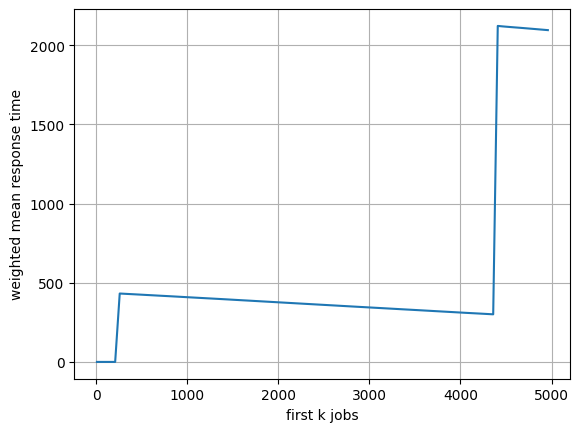

In [9]:
completed_jobs = main(7,7)

y = []
x = list(range(10, 5000, 50))
for i in x:
    y.append(moving_k_wmrt(completed_jobs, i)) 


plt.plot(x, y)
plt.xlabel('first k jobs')
plt.ylabel('weighted mean response time')
# plt.title('Result of main function over time')
plt.grid(True)
plt.show()